In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!ls gdrive/MyDrive/RLgitPurpose/hw2

images	runREINFORCE_baseline.ipynb  runREINFORCE.ipynb  utils


In [3]:
!mkdir utils
!cp ./gdrive/MyDrive/RLgitPurpose/hw2/utils/envs.py utils/envs.py
!cp ./gdrive/MyDrive/RLgitPurpose/hw2/utils/seed.py utils/seed.py
!cp ./gdrive/MyDrive/RLgitPurpose/hw2/utils/buffers.py utils/buffers.py
!cp ./gdrive/MyDrive/RLgitPurpose/hw2/utils/torch.py utils/torch.py

mkdir: cannot create directory ‘utils’: File exists


In [4]:
! ls utils

buffers.py  envs.py  __pycache__  seed.py  torch.py


In [5]:
from math import log
import gym
import numpy as np
import utils.envs, utils.seed, utils.buffers, utils.torch
import torch, random
from torch import nn
import copy
import tqdm
import matplotlib.pyplot as plt
import warnings
import argparse

warnings.filterwarnings("ignore")

In [16]:
# REINFORCE with baseline
# Slide 6
# cs.uwaterloo.ca/~ppoupart/teaching/cs885-fall21/slides/cs885-module1.pdf

# Constants
SEED = 1
t = utils.torch.TorchHelper()
DEVICE = t.device
mode = "cartpole"

#for cartpole
if mode == "cartpole":
    OBS_N = 4               # State space size
    ACT_N = 2               # Action space size
    ENV_NAME = "CartPole-v0"
    GAMMA = 1.0             # Discount factor in episodic reward objective
    LEARNING_RATE1 = 5e-4   # Learning rate for value optimizer
    LEARNING_RATE2 = 5e-4   # Learning rate for actor optimizer
elif "mountain_car" in mode:
    OBS_N = 2
    ACT_N = 3
    ENV_NAME = "MountainCar-v0"
    GAMMA = 0.9               # Discount factor in episodic reward objective
    LEARNING_RATE1 = 1e-3     # Learning rate for value optimizer
    LEARNING_RATE2 = 1e-3     # Learning rate for actor optimizer
 
EPOCHS = 800            # Total number of epochs to learn over
EPISODES_PER_EPOCH = 1  # Epsides per epoch
TEST_EPISODES = 10      # Test episodes
HIDDEN = 32             # Hidden size
POLICY_TRAIN_ITERS = 1  # Training epochs

# Create environment
utils.seed.seed(SEED)
env = gym.make(ENV_NAME)
env.seed(SEED)

# Networks
V = torch.nn.Sequential(
    torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN, 1)
).to(DEVICE)
pi = torch.nn.Sequential(
    torch.nn.Linear(OBS_N, HIDDEN), torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN, HIDDEN), torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN, ACT_N)
).to(DEVICE)

# Optimizers
OPT1 = torch.optim.Adam(V.parameters(), lr = LEARNING_RATE1)
OPT2 = torch.optim.Adam(pi.parameters(), lr = LEARNING_RATE2)

# Policy
def policy(env, obs):
    probs = torch.nn.Softmax(dim=-1)(pi(t.f(obs)))
    return np.random.choice(ACT_N, p = probs.cpu().detach().numpy())


# Training function
# S = tensor of states observed in the episode/ batch of episodes
# A = tensor of actions taken in episode/ batch of episodes
# return = tensor where nth element is \sum^{T-n}_0 gamma^n * reward (return at step n of episode)
def train(S,A,returns):
    ###############################
    # YOUR CODE HERE:

    # Implement the training of the value function (follow slides, doing a gradient update per
    # step in the episode)
    # ....

    OPT1.zero_grad()
    values = V(S).squeeze()
    deltas = returns - values
    n = torch.arange(S.size(0)).to(DEVICE)
    value_objective = -((GAMMA**n) *deltas * values).mean()
    value_objective.backward(retain_graph=True)
    OPT1.step()

    # policy gradient with baseline
    # apply accumulated gradient across the episode
    for i in range(POLICY_TRAIN_ITERS):
        # implement objective and update for policy
        # should be similar to REINFORCE + small change
        OPT2.zero_grad()
        # collect pi(a | s) for trajectories
        log_probs = torch.nn.LogSoftmax(dim=-1)(pi(S)).gather(1, A.view(-1, 1)).view(-1)
        # print('log_probs shape:', log_probs.shape)
        # print('deltas shape:', deltas.shape)      
        policy_objective = -((GAMMA**n) * deltas * log_probs).sum()
        policy_objective.backward(retain_graph=True)
        OPT2.step()    
        
    #################################

Training:


R25(192.76, mean over 10 episodes): 100%|██████████| 800/800 [00:53<00:00, 15.01it/s]


Training finished!
Episodic reward plot saved!
Testing:
Episode01: R = 199
Episode02: R = 200
Episode03: R = 200
Episode04: R = 200
Episode05: R = 200
Episode06: R = 200
Episode07: R = 200
Episode08: R = 200
Episode09: R = 200
Episode10: R = 200
Eval score: 199.90 ± 0.30


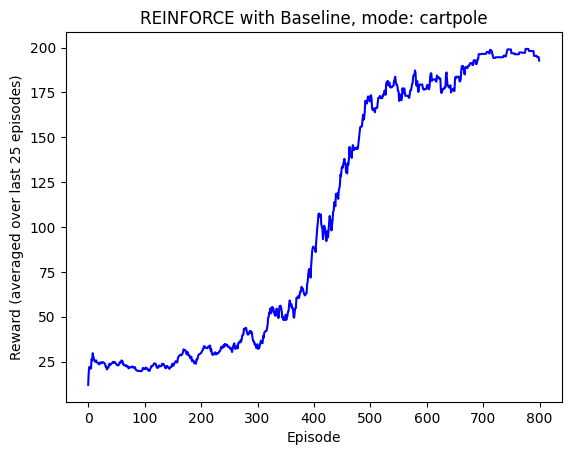

In [17]:
# Play episodes
Rs = [] 
last25Rs = []
print("Training:")
pbar = tqdm.trange(EPOCHS)
for epi in pbar:

    all_S, all_A = [], []
    all_returns = []
    for epj in range(EPISODES_PER_EPOCH):
        
        # Play an episode and log episodic reward
        S, A, R = utils.envs.play_episode(env, policy)

        #modify the reward for "mountain_car_mod" mode
        # replace reward with the height of the car (which is first component of state)
        if mode == "mountain_car_mod":
            R = [s[0] for s in S[:-1]]


        all_S += S[:-1] # ignore last state
        all_A += A
        
        # Create returns 
        discounted_rewards = copy.deepcopy(R)
        for i in range(len(R)-1)[::-1]:
            discounted_rewards[i] += GAMMA * discounted_rewards[i+1]
        discounted_rewards = t.f(discounted_rewards)
        all_returns += [discounted_rewards]

    Rs += [sum(R)]
    S, A = t.f(np.array(all_S)), t.l(np.array(all_A))

    returns = torch.cat(all_returns, dim=0).flatten()

    # train
    train(S, A, returns)

    # Show mean episodic reward over last 25 episodes
    last25Rs += [sum(Rs[-25:])/len(Rs[-25:])]
    pbar.set_description("R25(%g, mean over 10 episodes)" % (last25Rs[-1]))
  
pbar.close()
print("Training finished!")

# Plot the reward
N = len(last25Rs)
plt.plot(range(N), last25Rs, 'b')
plt.xlabel('Episode')
plt.ylabel('Reward (averaged over last 25 episodes)')
plt.title("REINFORCE with Baseline, mode: " + mode)
#plt.savefig("images/reinforce_baseline-"+mode+".png")
print("Episodic reward plot saved!")

# Play test episodes
print("Testing:")
testRs = []
for epi in range(TEST_EPISODES):
    S, A, R = utils.envs.play_episode(env, policy, render = False)

    #for mountain car environment, report the height the car achieved instead of reward
    #modify the reward for "mountain_car_mod" mode
    # replace reward with the height of the car (which is first component of state)
    if "mountain_car" in mode:
        R = [s[0] for s in S[:-1]]

    testRs += [sum(R)]
    print("Episode%02d: R = %g" % (epi+1, sum(R)))

if "mountain_car" in mode:
    print("Height achieved: %.2f ± %.2f" % (np.mean(testRs), np.std(testRs)))
else:
    print("Eval score: %.2f ± %.2f" % (np.mean(testRs), np.std(testRs)))
env.close()